# A/B Test - Sale Store website

An Sale Store desire implement a new website to improve the online sales. Before the official implementation, the store requested an A/B Test to verify if the use of the function "Buy" could growth the 5% desired, in the new website.

With the actual website version, the function "Buy" is activeted in 18% of the used times.

So, was defined two groups for the A/B Test: 

1. Control - This group tested the actual website version;
2. Treatment - This group tested the new website version.

With a confidence level of 95% - α = 0,05 - the test will verify the hypoteses:

* H0 = The new and the actual versions have the same performance;
* H1 = The new version increase 5% than the actual version.



The dataset utilized could be download in <https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv>

In [40]:
#Libraries
!pip install scipy==1.7.0 --user

from scipy import stats
import numpy as np
import pandas as pd
import scipy as sc
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil


# Plot styling
plt.style.use('seaborn-whitegrid')
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)



### Estimating sample size with Power analysis

In [ ]:
# Calculating effect size based on our expected rates - 0.18 actual percentage, 0.23 desired percentage
effect_size = sms.proportion_effectsize(0.18, 0.23)   
 
# Calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                        

required_n = ceil(required_n)                                               
print(required_n)

According with the Power analysis, the sample size will be with 1020 observations for each group involved in the test.

### Import Dataset

In [11]:
df = pd.read_csv(r'C:\Users\carol\OneDrive\Área de Trabalho\Estudos Data Science\Portfolio\AB_Test\ab_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [12]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Data Quality Analysis

In [5]:
#Confirm that the utilization are unique for each user - How much users appears more than 1 time?
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(multi_users)


3894


In [6]:
#The number 3894 is not significance for the dataset - drop
users_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
df.shape[0]



286690

In [9]:
#Look for null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### Separating the sample needed - 1020 for each group - 2040 observations in total

In [13]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       2040 non-null   int64 
 1   timestamp     2040 non-null   object
 2   group         2040 non-null   object
 3   landing_page  2040 non-null   object
 4   converted     2040 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 79.8+ KB


In [14]:
ab_test['group'].value_counts()

treatment    1020
control      1020
Name: group, dtype: int64

In [15]:
conversion_rates = ab_test.groupby('group')['converted']

# Std. deviation of the proportion
std_p = lambda x: np.std(x, ddof=0)

# Std. error of the proportion (std / sqrt(n))              
se_p = lambda x: stats.sem(x, ddof=0)            

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.122,0.327,0.010
treatment,0.115,0.319,0.010


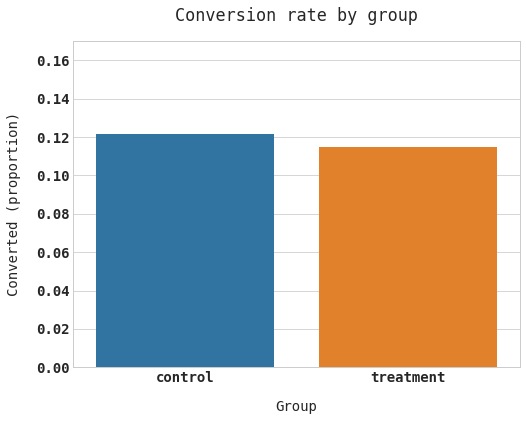

In [22]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

Apparently, the Treatment group had a small conversion rate.

### Testing the hyphoteses - T-test

Since the desire is compare the mean of different groups, it was used the T-test. To this, was assumed about the samples:
* Are independent;
* Are approximately normally distributed;
* They have similar amount of variance.

In [44]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [45]:
ttest = stats.ttest_rel(control_results, treatment_results)
ttest

Ttest_relResult(statistic=0.4728361001854367, pvalue=0.6364313755734903)

### Result
Since the p-value - 0.63 - is higher than the α defined - 0,05 - we cannot reject H0. 
With that, we can conclusion that the new version of the website may not have the desired performance.